In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import olac.maths as mf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
from __future__ import division, print_function
import numpy as np

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"


def detect_cusum(x, threshold=2, drift=0):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    pos_csum = [0, 0]  # gp
    neg_csum = [0, 0]  # gn

    x = np.atleast_1d(x).astype('float64')
    alarm_index = []
    change_index = []
    pos_alarm_index = 0
    neg_alarm_index = 0

    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        pos_csum.append(pos_csum[i-1] + s - drift)  # cumulative sum for + change
        neg_csum.append(neg_csum[i-1] - s - drift)  # cumulative sum for - change

        if pos_csum[i] < 0:
            pos_csum[i], pos_alarm_index = 0, i
        if neg_csum[i] < 0:
            neg_csum[i], neg_alarm_index = 0, i
        if pos_csum[i] > threshold or neg_csum[i] > threshold:  # change detected!
            alarm_index = np.append(alarm_index, i)    # alarm index
            if pos_csum[i] > threshold:
                change_index = np.append(change_index, pos_alarm_index)  # start
            else:
                change_index = np.append(change_index, neg_alarm_index)  # start

            pos_csum[i], neg_csum[i] = 0, 0      # reset alarm

    return alarm_index, change_index

In [5]:
import numpy as np
import pandas as pd


class K_ADWIN(object):
    """

    Parameters
    ----------

    Attributes
    ----------
    labels_ : The cluster labels identified during fitting
    components_ : The vector array input used in fitting

    _dbscan : The internal DBSCAN classifier
    _meanshift : The internal Mean Shift classifier
    _knn : The internal KNN classifier
    """
    def __init__(self):
        """
        
        """
        self.wup = None
        self.wlow = None
        
        self.data_id = 0
        self.memory_id = 0
        
        self.cluster_store = {}
        self.templ = {'prob': 0.5, 'cnt': 0, 'frauds': 0, 'labels':0 }
    
        self.data_store = pd.DataFrame([], columns=['x1', 'x2', 'cl_id', 'prob', 'label', 'fraud'])
        
    
        self.memory = self.data_store.loc[self.wlow:self.wup]
        
        ############################################################################################
        #                                        CUSUM
        ############################################################################################
        self.pos_csum = [0]
        self.neg_csum = [0] 

        self.alarm_index = []  # alarm time (index of when the change was detected)
        self.change_index = []  #  index of when the change started
        self.pos_alarm_index = 0
        self.neg_alarm_index = 0
        
        self.alarm = False
    
    def __update_memory_store(self):
        self.memory_snapshots = {self.memory_id: self.memory.to_dict('series')}
    
    def __update_unique_clusters(self):
        self.uniq_clusters = np.unique(self.data_store['cl_id'])
        
    def __update_cluster_store(self):
        templ = {'prob': 0.5, 'cnt': 0, 'frauds': 0, 'labels':0 }
        for cl_id in self.uniq_clusters:
            tmp = self.memory[self.memory['cl_id'] == cl_id]
            self.cluster_store[cl_id] = {'cnt': tmp.shape[0],
                                         'frauds': tmp['fraud'].sum(),
                                         'labels': tmp['label'].sum(),
                                         'prob': np.mean(self.memory['prob'])}
            
    def CUSUM(self, threshold=3, drift=0):
        """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

        Parameters
        ----------
        x : 1D array_like
            data
        threshold : positive number, optional (default = 1)
            amplitude threshold for the change in the data.
        drift : positive number, optional (default = 0)
            drift term that prevents any change in the absence of change.

        Returns
        -------
        ta : 1D array_like [indi, indf], int
            alarm time (index of when the change was detected).
        tai : 1D array_like, int
            index of when the change started.

        self.alarm_ind = []
        self.shift_ind = []

        Notes
        -----
        Adapted from:
            Marcos Duarte
            github.com/demotu/BMC/
            
        Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
        Start with a very large `threshold`.
        Choose `drift` to one half of the expected change, or adjust `drift` such
        that `g` = 0 more than 50% of the time.
        Then set the `threshold` so the required number of false alarms (this can
        be done automatically) or delay for detection is obtained.
        If faster detection is sought, try to decrease `drift`.
        If fewer false alarms are wanted, try to increase `drift`.
        If there is a subset of the change times that does not make sense,
        try to increase `drift`.

        Note that by default repeated sequential changes, i.e., changes that have
        the same beginning (`tai`) are not deleted because the changes were
        detected by the alarm (`ta`) at different instants. This is how the
        classical CUSUM algorithm operates.

        If you want to delete the repeated sequential changes and keep only the
        beginning of the first sequential change, set the parameter `ending` to
        True. In this case, the index of the ending of the change (`taf`) and the
        amplitude of the change (or of the total amplitude for a repeated
        sequential change) are calculated and only the first change of the repeated
        sequential changes is kept. In this case, it is likely that `ta`, `tai`,
        and `taf` will have less values than when `ending` was set to False.

        See this IPython Notebook [2]_.

        References
        ----------
        .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
        .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb
        """
        # Reset alarm
        self.alarm = False

        s = self.kalman_estimates[-1] - self.kalman_estimates[-2]
        pos_csum = self.pos_csum[-1] + s - drift  # cumulative sum for + change
        neg_csum = self.neg_csum[-1] - s - drift  # cumulative sum for - change

        if pos_csum < 0:
            print(pos_csum)
            self.pos_csum.append(0)
            self.pos_alarm_index = self.data_id

        if neg_csum < 0:
            print(neg_csum)
            self.neg_csum.append(0)
            self.neg_alarm_index = self.data_id

        if pos_csum > threshold or neg_csum > threshold:  # change detected!

            self.alarm = True
            self.alarm_index.append(self.data_id)    # alarm index

            if pos_csum > threshold:
                self.change_index.append(self.pos_alarm_index)  # start
            else:
                self.change_index.append(self.neg_alarm_index)  # start

            self.pos_csum.append(0)  # reset alarm
            self.neg_csum.append(0)  # reset alarm
        
    
    def test_CUSUM(self):
        cnt = 0
        self.kalman_estimates = [0, 0]
        while not self.alarm:
            self.kalman_estimates.append(self.data_store.loc[cnt, 'x1'])
            self.CUSUM()
            print(self.alarm)
            cnt += 1

In [6]:
kadwin = K_ADWIN()

In [7]:
kadwin.memory

,x1,x2,cl_id,prob,label,fraud


In [8]:
kadwin.data_store

,x1,x2,cl_id,prob,label,fraud


In [9]:
n = 1000

In [23]:
arr1 = np.random.normal(0, 0.3, size=(n, 1))
arr2 = np.random.normal(0, 1, size=(100, 1))
arr3 = np.random.normal(0, 0.3, size=(n, 1))

arr = np.vstack((arr1, arr2, arr3))

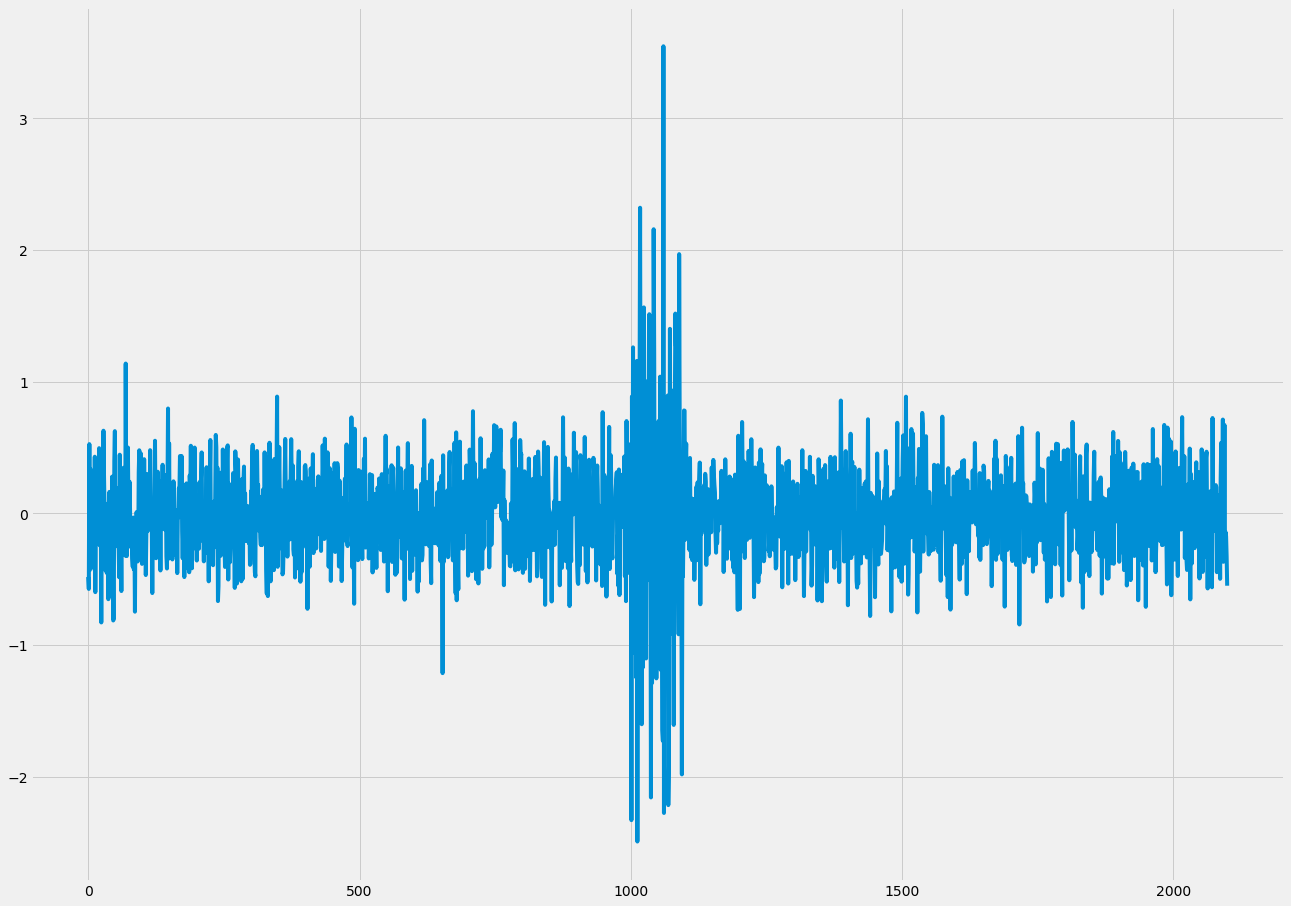

In [24]:
plt.figure(figsize=(20, 15))
plt.plot(arr)

In [ ]:
def

In [285]:
kadwin.data_store[['x1', 'x2']] = pd.DataFrame(arr)

In [286]:
kadwin.data_store['prob'] = 0.5

In [287]:
kadwin.data_store[['label', 'fraud']] = 0

In [288]:
s1 = np.std(kadwin.data_store.loc[:1001, 'x1'].values)

In [289]:
s1 * 3

3.0058230711272587

In [290]:
kadwin.test_CUSUM()

-1.2181070917988306
False
-2.487422112092909
False
-0.9429466347068401
False
-0.45757938723977576
False
-1.3243907825528585
False
-0.2733453017452194
False
-0.5752648783738812
False
-0.3924605836125563
False
-2.446931336377096
False
-1.1140973145092825
False
-2.192481269269667
False
-1.1508792684642912
False
-2.1008190373364357
False
-1.9796925910603647
False
-0.18013845829473196
False
-0.11952577474941217
False
-1.8825926549298932
False
-2.2407839712222484
False
-2.7525181249783115
False
-2.9431605633161477
False
-0.07121701669637054
False
-0.5079598724990068
False
-1.941387818295478
False
-3.4831462022352166
True


In [241]:
detect_cusum(arr[:, 0], 5)

(array([  24.,   25.,   70.,   71.,  132.,  133.,  162.,  175.,  198.,
         211.,  218.,  233.,  245.,  252.,  271.,  272.,  279.,  288.,
         317.,  318.,  328.,  329.,  369.,  372.,  384.,  390.,  411.,
         412.,  423.,  430.,  443.,  444.,  453.,  454.,  463.,  464.,
         471.,  474.,  512.,  513.,  541.,  542.,  563.,  564.,  606.,
         607.,  632.,  635.,  657.,  676.,  677.,  684.,  696.,  697.,
         764.,  772.,  786.,  789.,  818.,  819.,  841.,  846.,  879.,
         880.,  890.,  895.,  902.,  921.,  926.,  946.,  947.,  959.,
         960.,  974.,  975.,  993., 1002., 1008., 1015., 1016., 1028.,
        1033., 1039., 1040., 1058., 1059., 1069., 1070., 1078., 1081.,
        1087., 1090., 1107., 1110., 1139., 1154., 1155., 1183., 1184.,
        1193., 1204., 1223., 1224., 1229., 1232., 1236., 1237., 1244.,
        1258., 1259., 1263., 1273., 1276., 1284., 1285., 1290., 1300.,
        1301., 1311., 1314., 1319., 1320., 1330., 1331., 1366., 1373.,
      

In [223]:
arr

array([[-0.23428008, -0.62657984],
       [-0.38508662,  1.50814574],
       [ 0.01599863, -1.39611075],
       ...,
       [ 0.9815106 ,  3.54738085],
       [ 0.91373931, -0.63027629],
       [ 0.71960776, -0.66654665]])